# TIME SERIES FORECASTING 

A time series data is the data on a response variable Yt observed at different points in time t. Data on the variable is collected at regular intervals and in a chronological order. Anything that is observed sequentially over time is time series. 

For e.g. data collected on the sale of smartphones over several time intervals, the GDP of a nation each year, electricity production every year/month etc are all examples of time series data. 
<br>
<br>
The aim of forecasting time series data is to understand how the sequence of observations will continue in the future.
<br>
<br>
A time series data will have one or more than one of these following components: 
1. Trend Component - It is the consistent upward or downward movement of the data over the entire time span. The trend can be both linear and non linear
<br>
2. Seasonality Component - It is the repetitive upward or downward fluctuation from the trend that occurs within a calendar year at fixed intervals. It always has a fixed and a known frequency.
<br>
3. Cyclical Component - Cyclical fluctuations occur due to macro economic factors like recession. Here, the interval between the repetition is more than a few years. Periodicty of cyclical fluctuation is not fixed. The average length of cyclical pattern is longer than the average length of the seasonal pattern.
<br>
4. Irregular Fluctuation (Also called White Noise) - It is the uncorrelated random component of the time series data. If the time series data only has White Noise as a component, it cannot be used for prediction. This is because the series has observations which are identically and independently distributed with a mean of 0 and a constant variance. 
<br>

The choice of the forecasting method will depend on the component present in the time series. Usually the time series data will have both trend and seasonality components present. A number of time series forecasting methods such as Moving Average, Weighted Moving Average, ARIMA, SARIMA etc are used for forecasting. 

We will use the data on the Industrial Production - Utilities to understand the time series forecasting better. 
<br>
The data used can be sourced from this link : https://fred.stlouisfed.org/series/IPG2211A2N
<br>
The data set gives the monthly industrial production of all gas and electrical utilities in the United States from 1940 to 2020.



In [5]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy import mean
from sklearn.metrics import mean_squared_error
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.api import ExponentialSmoothing
from matplotlib import pyplot
import warnings
import itertools

In [2]:
import os

In [3]:
os.getcwd()

'C:\\Users\\91916\\Desktop\\1 IIMB Course\\Extras\\My Projects\\ARIMA Time Series'

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
df = pd.read_csv('C:\\Users\\91916\\Desktop\\1 IIMB Course\\Extras\\My Projects\\ARIMA Time Series\\Data.csv')

In [6]:
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3298
1,1939-02-01,3.3552
2,1939-03-01,3.4315
3,1939-04-01,3.4569
4,1939-05-01,3.4569


In [7]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        989 non-null    object 
 1   IPG2211A2N  989 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.7+ KB


(989, 2)

Here the Date column is an object. We need to convert it into date time. We will rename the name of the second column

In [8]:
import datetime

In [9]:
df['Date'] = pd.to_datetime(df['DATE'], dayfirst=True)
df[['Date','DATE']].head(2)

,Date,DATE
0,1939-01-01,1939-01-01
1,1939-02-01,1939-02-01


In [10]:
df.drop(['DATE'], axis=1, inplace=True)

In [11]:
df = df.rename(columns={'IPG2211A2N' :'Energy_Production'})

In [12]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Energy_Production  989 non-null    float64       
 1   Date               989 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.5 KB


(989, 2)

There are 989 observations in the dataframe and no missing data. Lets plot the time series. 

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Energy Production')

Text(0.5, 1.0, 'Trend of Energy Production')

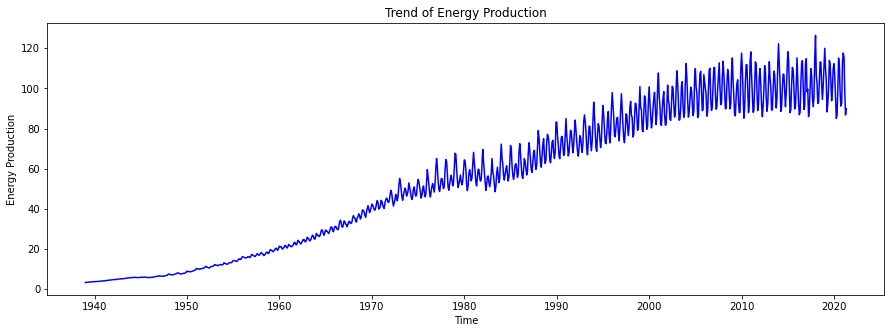

In [13]:
plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Energy Production')
plt.title('Trend of Energy Production')
plt.plot(df['Date'], df['Energy_Production'],'b-')

If we plot the energy production, we can observe that there is both trend and seasonality. We can decompose the time series data into its individial components using the function 'decompose' in Python.
<br>
<br>
On using this function, we get four different plots. These include the overall visual plot of the series, the trend component, the seasonal component and the residual.If we observe these individual plots, we can infer that both the trend and seasonal components are present in the time series and it is additive. What does this mean? 
<br>
<br>
<b> Additive time series <b> is one in which the magnitude of trend and seasonality does not increase with time. They remain fairly constant. 
<b> Multiplicative time series <b> is one in which the magnitude of trend and seasonality increases as time period increases.

Our data here is aggregated by month. The period we want to analyze is by year so that's why we set the period frequency to 12.

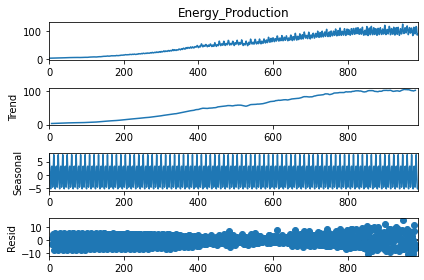

In [14]:
y_decompose = seasonal_decompose(df['Energy_Production'], model = 'additive', freq = 12)
y_decompose_plot = y_decompose.plot()

We can observe the seasonal and tend components in more detail in the below graphs

# Seasonal Component of Time Series

<Figure size 1080x216 with 0 Axes>

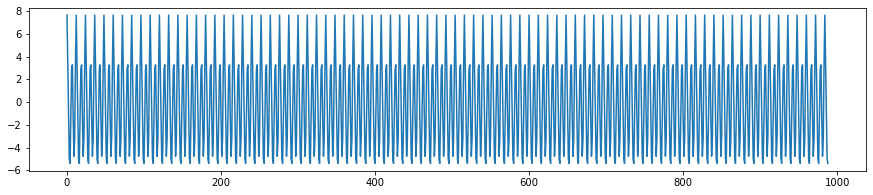

In [15]:
plt.figure(figsize=(15,3))
y_decompose.seasonal.plot()

# Trend Component of Time Series

<Figure size 1080x216 with 0 Axes>

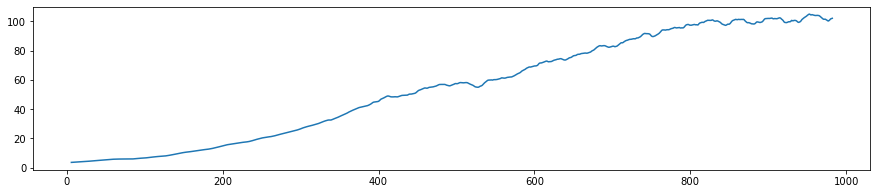

In [16]:
plt.figure(figsize=(15,3))
y_decompose.trend.plot()

From the plots above, we can conclude that there is both seasonality and trend present in the data. 

We will first use simple methods of forecasting, check the error metrics (RMSE and MAPE) and then use more complex forecasting measures like ARIMA

# Method 1 Moving Average Method

This method is more suitable for data which does not have strong trend and seasonality components. 

Moving Average Method is one of the simplest forecasting method that forecasts the future value of a time series data using 
average of the past N observations. Here, N is the hyperparameter. If the series is more or less stable, a lower value of N 
can be taken. If the series is very volatile, a higher value of N should be taken. 
The given time series is highly seasonal and also has a strong trend. Moving Average method of forecasting will not work here. However, we will still go ahead with it to understand why it is not the best model.

We will take a 12 month moving average as we are looking at monthly data and the pattern repeats itself every year. We will then plot the actual and predicted trend and observe how close/distant the predicted value is from the actual time series. 

In [17]:
df1 = df.copy()
df1['Moving Avg_12'] = df1['Energy_Production'].rolling(window=12).mean().shift(1)

No handles with labels found to put in legend.


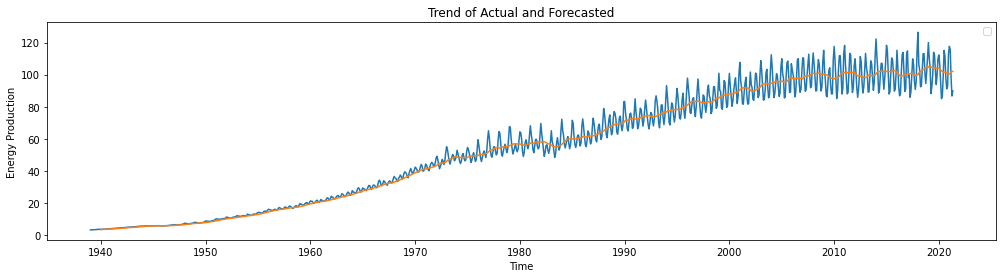

In [18]:
# Lets plot the two time series 
plt.figure(figsize=(17,4))
plt.ylabel('Energy Production')
plt.xlabel('Time')
plt.title('Trend of Actual and Forecasted')
plt.plot(df1['Date'], df1[['Energy_Production','Moving Avg_12']])
plt.legend();

Clearly the Moving Average Method gives the average trend. It does not reflect the peak and troughs of the actual data.
Hence, in this case we cannot predict the production using Moving Average Method. 
We will check the forcast accuracy using metrics like RMSE (Root Mean Square Error) and MAPE (Mean Absolute Percentage Error). Other metrics used are Mean Square Error  (MSE) and Mean Absolute Error (MAE).

We will build a custom function to calculate MAPE. For RMSE, python has an in built function. We will check the accuracy on the test data that has the last 60 observations i.e. latest 5 year data 

In [19]:
# Function for MAPE
def get_mape(actual, predicted):
    return np.round(np.mean(np.abs((actual-predicted) / actual))*100,2)

In [20]:
get_mape(df1['Energy_Production'][928:].values, df1['Moving Avg_12'][928:].values)

8.48

In [21]:
#Calculate RMSE

In [22]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(df1['Energy_Production'][928:].values, df1['Moving Avg_12'][928:].values))

10.158717013618572

<b>Thus, the forecast accuracy metrics for 12 month moving average method is :
    RMSE = 10.15
    MAPE = 8.48 <b>

This can definetely be improved further using more advanced methods. 

<br>

# Method 2 : Exponential Smoothing Methods

The drawback of  Simple Moving Average Method is that it gives equal weight to all the observations. The Exponential Smoothing Method removes this limitation by assigning differential weights to the past observations. Here, the weights assigned to past data decline exponentially with the most recent observations assigned higher weights. The rate at which the weights decreases is controlled by a hyperparameter. 
<br>
<br>
Exponential Smoothing Methods are of three types : Single Exponential Smoothing, Double Exponential Smoothing and Triple Exponential Smoothing or Holt Winters Method. 

<b>Single Exponential Smoothing : <b>

This addresses only the level component of the time series. It uses a hyper parameter alpha which is called a smoothing constant.Its value lies between 0 and 1. Since only one smoothing constant is used, it is called Single Exponential Smoothing.
<br>
Here the forecast at time t is given as  Ft = alpha * yt-1 + (1-alpha)Ft-1
<br>
F1 is taken as y1 and then the above equation is used to calculate the remaining forecasts. 
<br>

<b> Double Exponential Smoothing <b>

This addresses both the level(l) and trend (b) component of the time series. Thus, two smoothing constants are used. Alpha for the level
component and beta for the trend component. The equations are as follows:
<br>
lt = alpha *(yt) + (1-alpha)(lt-1+bt-1) ---> Level l
<br>
bt = beta * (lt-lt-1) + (1-beta)(bt-1) ---> Trend b
<br>
yt+1 = lt + bt ---> Forecast 
<br>
The above term yt combines both the level and trend components. Initial values of lt is taken as yt. The starting value of
bt is taken as (Yt-Yt-1)

Single Exponential Smoothing method assumes the time series to be relatively stable with no trend and seasonality. However,  in this case, the data exhibits strong trend and seasonality. Thus, we cannot use single exponential method of forecasting. The double exponential smoothing method takes account of the average or level component and trend component. It does not account for seasonality. Thus, we cannot use double exponential smoothing as well. 

We will thus use Triple Exponential Smoothing, also known as Holt Winter Model. It takes into account level, trend and seasonal components. 

<b> Triple Exponential Smoothing / Holt Winter's Method : <b>

In this method, we apply smoothing to seasonal component in addition to level and trend components. The smoothing is applied 
across seasons. That is, the fourth component of one season is smoothed against the fourth component of the previous season, 
fourth component of two seasons ago and so on. Thus, there will be four equations - one each for level, trend, seasonality  and the final equation with all the individual components.

The equations vary given the model is additive or multiplicative. Honestly, one needs to put in significant effort to 
understand the math behind these equations. In case you want to go into more depth on the intuition behind the equations, 
you can refer to this link : https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/

The four equations of the additive Holt Winter's Method is given as : 
Here s is the Season Length i.e. the number of data points after which a new season begins. 

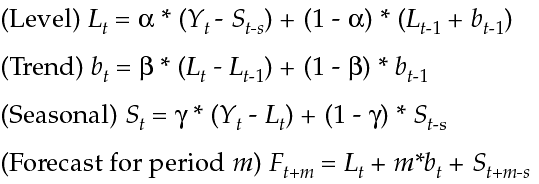

Lets see how to code the Triple Exponential Smoothing in Python. 

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [24]:
fit1 = ExponentialSmoothing(np.asarray(df1['Energy_Production'][:928].values), seasonal_periods=12 ,trend='add', seasonal='add',).fit()
fit1.summary()

Dep. Variable:,endog,No. Observations:,928
Model:,ExponentialSmoothing,SSE,2846.672
Optimized:,True,AIC,1072.171
Trend:,Additive,BIC,1149.500
Seasonal:,Additive,AICC,1072.924
Seasonal Periods:,12,Date:,"Sat, 17 Jul 2021"
Box-Cox:,False,Time:,14:39:06
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4085441,alpha,True
smoothing_slope,5.4582e-17,beta,True


We will now check the model on the test data.After prediction, we will plot the actual test data and predicted data. 

In [25]:
train_data = df1['Energy_Production'][:928]
test_data = df1['Energy_Production'][928:]
y_hat_avg = test_data.copy()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test_data))

In [26]:
rms = math.sqrt(mean_squared_error(test_data, y_hat_avg.Holt_Winter))
print(rms)

3.9916714233453447


In [27]:
get_mape(test_data, y_hat_avg.Holt_Winter)

3.27

Text(0.5, 1.0, 'Actual Production vs. Predicted Output')

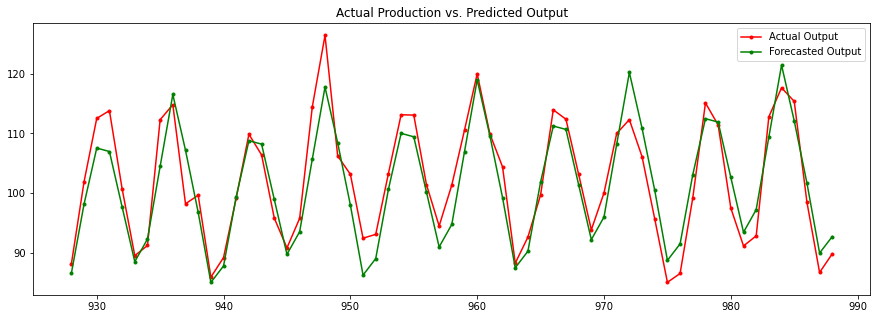

In [28]:
fig = plt.figure(figsize=(15,5))
future, = plt.plot(test_data.index, test_data, 'r.-', label='Actual Output')
predicted_future, = plt.plot(test_data.index, y_hat_avg.Holt_Winter, 'g.-', label='Forecasted Output')
plt.legend(handles=[future, predicted_future])
plt.title('Actual Production vs. Predicted Output')
plt.show()

We can see that the forecasted output closely follows the actual output.  

<b> The forecast accuracy of Triple Exponential Smoothing Method is : RMSE of 3.99 and MAPE of 3.27 <b>

<b>

<b>

# Method 3 : Seasonal Auto Regressive Integrated Moving Average (SARIMA)

ARIMA is a statistical model used for forecasting time series data. It describes the autocorrelation present in the data. As the name suggest, it consists of three terms.

<b> AR : Auto Regression : The time series is regressed with its previous values <b>

<b> I : Integration : The time series uses differencing to make it stationary <b>

<b> MA : Moving Average : The time series is regressed with residuals of the past observations <b>

ARIMA by itself does not support seasonal data. For time series that has a significant seasonal pattern, seasonal ARIMA models are used.

<b> SARIMA is short for seasonal ARIMA. Its an extension of ARIMA method that supports seasonality in data. 
In addition to the three parameters in ARIMA i.e. p,d,q, SARIMA has three more seasonal parameters (P,D,Q). The additional three parameters account for Autoregressive component, Differencing component and Moving Average Component at the Seasonal Level. 
<br>
<br>
It can be expressed as follows: ARIMA (p,d,q) (P,D,Q)m 
<br>
Here m is number of observations per season. The seasonal components of the model are expressed in upper case and non seasonal components of the model are expressed in lower case. <b>

Before we get into the details of SARIMA, lets understand the term 'Autocorrelation' and 'Partial Autocorrelation'. 
This method extensively uses autocorrelation and partial autocorrelation. Hence it is important to understand these concepts. 

<b>Auto-Correlation Function (ACF) : Auto-correlation of lag k is the correlation between Yt and Yt-k, measured at different k values. For lag 1, Auto correlation is measured between Yt and Yt-1, similarly for lag 2, Auto correlation is measured between Yt and Yt-2 values. A plot of auto-correlation for different values of k is called an auto-correlation plot or correlogram.<b>

<b> Partial Auto-Correlation (PACF) : Partial Auto Correlation of lag k is the correlation between Yt and Yt-k when the effectof all other intermediate values (Yt-1, Yt-2,....Yt-k+1) is removed from both Yt and Yt-k. A plot of partial auto correlation for different values of k is called partial auto correlation plot . <b>

Before we use ARIMA, we need to ensure that the time series is stationary. 

<b> What do you mean by stationarity of time series? <b>

A time series is said to be stationary if it has the following three properties: 
1. It has a constant mean i.e. mean remains constant over time
2. It has a constant variance i.e. variance remains constant over time
3. It has a constant covariance. Value of the covariance between the two time periods depend on the lag between the two time periods and not on the actual time at which the covariance is computed.

A stationary time series will have the same mean, variance and covariance no matter at what point we measure them, these are then actually time invariant. 

<b> Why do we need stationary time series? Because if the time series is not stationary, we can study its behavior only for that time period. Each period of the time series will have its own distinct behaviour and it is not possible to predict or generalize for future time periods. <b>

A stationary time series will tend to return to its mean value and the fluctuations around this mean will have a broadly constant magnitude.
Thus, a stationary time series will not drift too much from its mean value because of the finite variance.A time series with white noise is a stationary series cause it has no predictable patterns in the long term and has a constant variance.It is memoryless. 

Here is how a distribution of White Noise will look like: 

<Figure size 1080x288 with 0 Axes>

Text(0.5, 1.0, 'Distribution of White Noise')

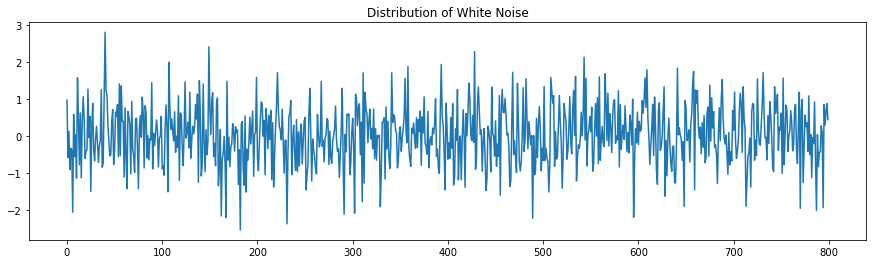

In [29]:
# Plot for White Noise with Mean 0 and standard deviation as 0.8
wnoise= np.random.normal(loc=0, scale=0.8, size=800)
plt.figure(figsize=(15, 4))
plt.plot(wnoise)
plt.title('Distribution of White Noise')

As you can see from the plot above, the distribution is constant across the mean and is completely random. Its difficult to predict the next movement of the time series. If I plot the autocorrelation of this series, one will observe complete zero autocorrelations. 

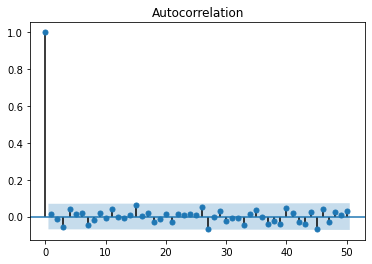

In [30]:
acr = plot_acf(wnoise, lags = 50)

<b> How do we check for stationarity? <b>


To check for stationarity, we use a statistical test known as Dickey Fuller Test. This test belongs to the category called the Unit Root test. 


The test checks whether the time series has a unit root and hence is non stationary. 
<br>
<br>
Null Hypothesis Ho : There is a unit root i.e. the time series is non stationary
<br>
Alternate Hypothesis Ha : There is no unit root i.e. the time series is stationary

<b> What do you mean by Unit Root? <b>

A non stationary time series will have a unit root. Thus, when we check for stationarity, we check for unit root. If 
the time series has an unit root, we conclude that the series is not stationary.
<br>
There are two kinds of non stationary stochastic time series that are observed :
    1. Random Walk Model Without Drift (RWM)
    2. Random Walk Model with Drift 

In Random Walk Without Drift, the mean of the series is constant but the variance increases with time. Thus the series is non stationary. Usually, the stock prices are considered to be Random Walk. <br>
In a time series with Random Walk, the value of the time series Y at time t is equal to its value at time t-1 plus a random shock i.e. 
Yt = Yt-1 + ut
<br>
The first difference of the Random Walk Without Drift is a stationary time series. Why? Cause Yt - Yt-1 = ut is a white noise or stationary series with mean 0 and constant variance
<br>
<br>
In Random Walk With Drift, both the mean of the series and the variance increase with time. Thus, the series is not stationary. In a Random Walk With Drift, the value of time series at time t is equal to its value at time t-1 plus a drift parameter delta plus a random shock i.e. Yt = Yt-1 + delta + ut
<br>
<br>
A Random Walk Model is known as a unit root process. It is written as :
Yt = (Delta)* Yt-1 + ut, where the value of delta is between -1 and 1. 
<br>
<br>
If the value of delta is 1 or greater than 1, the series is non stationary. If the value of delta is less than 1, we conclude that the series is stationary

<b> We will perform the Dickey Fuller Test on the given time series to confirm stationarity. <b>

<b> Null Hypothesis Ho : Series has a unit root i.e. non stationary time series
<br>
Alternate Hypothesis Ha : Series does not have a unit root i.e. stationary time series
<b>

In [9]:
#df1.head()

In [68]:
df2 = df1[['Energy_Production','Date']]

In [69]:
df2.set_index('Date', inplace=True)
df2.head()

,Energy_Production
Date,
1939-01-01,3.3298
1939-02-01,3.3552
1939-03-01,3.4315
1939-04-01,3.4569
1939-05-01,3.4569


In [71]:
X = df2['Energy_Production'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.671461
p-value: 0.854004
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


<b> As the p value is greater than 5%, we will accept the Null Hypothesis. Thus, the series is non stationary.<b> 

If the series is non stationary, we need to transform the series to make it stationary so that it can be used for prediction.
One of the ways to transform the data is to do differencing if it is a stochastic non stationary series and detrending if it is a deterministic non stationary time series. 

We will difference the time series to make the it stationary. We will use the differencing of order 12 as it is monthly data - subtraction of series from itself with lag 12

In [32]:
df1['Energy_Production_diff'] = df1['Energy_Production'] - df1['Energy_Production'].shift(12)
df1[['Energy_Production','Energy_Production_diff']].head()

,Energy_Production,Energy_Production_diff
0,3.3298,NaN
1,3.3552,NaN
2,3.4315,NaN
3,3.4569,NaN
4,3.4569,NaN


We need to remove the NaN values for further processing. We will further plot the data to see if the trend and seasonality has been accounted for.

In [33]:
df1['Energy_Production_diff1'] = df1['Energy_Production_diff'].dropna()

<Figure size 1296x360 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Energy Production')

Text(0.5, 1.0, 'Differenced Time Series of Energy Production')

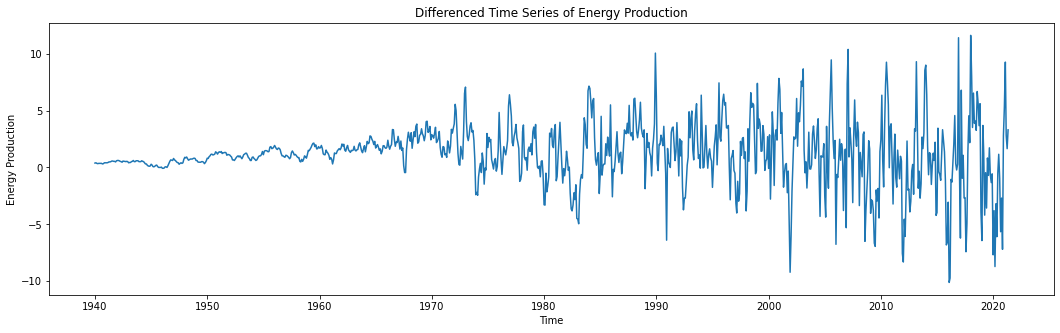

In [34]:
plt.figure(figsize=(18,5))
plt.xlabel('Time')
plt.ylabel('Energy Production')
plt.title('Differenced Time Series of Energy Production')
plt.plot(df1['Date'], df1['Energy_Production_diff1'])

We can conclude that the trend and seasonality has been removed after seasonal differencing. We will run the Dickey Fuller Test on the differenced data to check if the series is stationary. 

In [35]:
X = df1['Energy_Production_diff1'].dropna().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.978133
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


The Dickey Fuller test confirms that the series is stationary. We will also check the ACF and PACF plots to look at the significant lags.

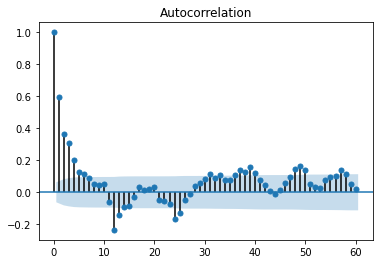

In [36]:
acf_plot = plot_acf(df1['Energy_Production_diff1'].dropna(), lags= 60) 

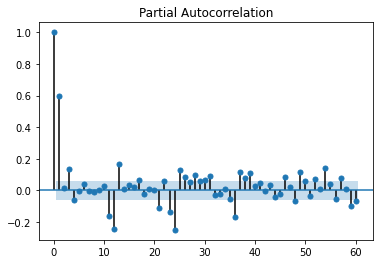

In [37]:
pacf_plot = plot_pacf(df1['Energy_Production_diff1'].dropna(), lags= 60) 

We can see that autocorrelation function still has many significant lags. To remove them we will take first differences — subtraction of series from itself with lag 1

In [38]:
df1['Energy_Production_diff121'] = df1['Energy_Production_diff1'] - df1['Energy_Production_diff1'].shift(1)

In [39]:
df1['Energy_Production_diff121'] = df1['Energy_Production_diff121'].dropna()

In [40]:
X = df1['Energy_Production_diff121'].dropna().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.397464
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


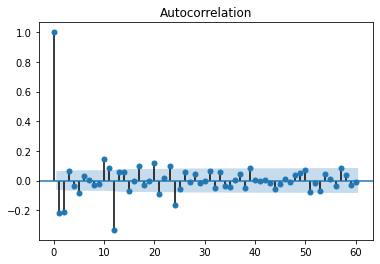

In [41]:
acf_plot = plot_acf(df1['Energy_Production_diff121'].dropna(), lags= 60) 

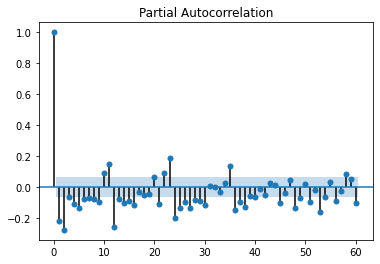

In [42]:
pacf_plot = plot_pacf(df1['Energy_Production_diff121'].dropna(), lags= 60) 

<Figure size 1296x360 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Energy Production')

Text(0.5, 1.0, 'Differenced Time Series of Energy Production')

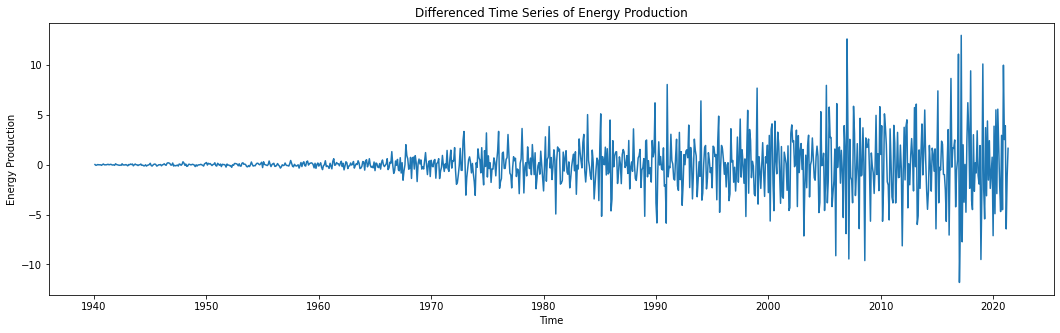

In [43]:
plt.figure(figsize=(18,5))
plt.xlabel('Time')
plt.ylabel('Energy Production')
plt.title('Differenced Time Series of Energy Production')
plt.plot(df1['Date'], df1['Energy_Production_diff121'])

The number of significant lags have been reduced and the Dickey Fuller test confirms that the series is stationary. 
We can now start forecasting. We specify the original series as the data and then indicate the desired differencing when specifying parameters in the python function.  

In our case, the order of D (Seasonal Differencing) is 1 and the order of d (non seasonal differencing) is also 1. How do we go about setting other parameters?

<b> To determine the seasonal and non seasonal AR and MA terms, one of the standard approaches is to use the auto correlation function (ACF) and partial auto correlation function (PACF) <b>

To determine the non seasonal parameters, we should look at the early lags in PACF and ACF plot to determine p and q respectively. Spikes in the PACF and ACF plots at early lags indicate possible AR (p) and MA(q) terms. 

AR(p) : Here, the basic assumption is that the current series values depend on its previous values with some lag. The maximum lag in the model is referred to as p. To determine the initial p you need to have a look at PACF plot — find the biggest significant lag after which most other lags are becoming not significant.


MA(q) : Here, the basic assumption is that current error depends on the previous error with some lag which is referred to as q. To determine the initial q you need to have a look at ACF plot — find the biggest significant lag, after which most other lags are becoming not significant.

To determine the seasonal parameters, we need to look at lags that are multiples of S. If it monthly data, which is the case here, we will look at the lags 12,24,36 and so on. We will determine the values of P and Q using the same reasoning we used above. 

Seasonal AR (P) : We will look at the significant lags which are multiples of 12 in the PACF plot and select the order for which the lag is most significant

Seasonal MA (Q) :We will look at the significant lags which are multiples of 12 in the ACF plot and select the order for which the lag is most significant. 

With these in mind, the initial parameters will be: <br>
p = 2, q =2, d =1, P = 2, D = 1, Q=2

We now have a range of the parameters. We will use a grid search to select the best model with the parameters within the range defined above. The best model will be selected using AIC as a metric. What is AIC (Akaike Information Criterion)?

AIC is used as a relative metric to compare different models. It determines which model is the best given a set of models created for a given data. Lower the AIC of the model, the better it is. This metric is especially useful if you have limited data for training and you end up using the entire data for modeling. In such a case,AIC helps to serve as a useful metric of model selection. 

In [94]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [124]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:11059.616094449666
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:9671.108414752765
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:8754.858508543579
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4842.438770481836
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4796.404187877576
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:4748.144875463489
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:5465.162229888487
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:4605.605700412258
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:4431.011497701212
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4738.483635841763
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4708.494551919897
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:4664.085849400465
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4800.369887858698
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:4657.5219758861185
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:4476.0102848416445
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:5105.911753959932
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:4555.230000657059
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:4433.429976331889
ARIMA(0

ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:3870.545179258948
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:4766.900027183414
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:4123.884687669257
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:3863.796370648809
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:4120.304434130461
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:3912.708576741037
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:3888.0207171961656
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:3954.8924458243137
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:3859.358875308136
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:3846.26142247699
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:4477.8176544340095
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:3961.2433662617086
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:3843.149540071551
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:6408.777611381036
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:5786.219030807709
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:5534.752693255934
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:5307.191822239727
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:4937.734223431768
ARIMA(0

ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:5007.933607758729
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:4700.395967855784
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:4239.54987426327
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:3923.469700048735
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:3880.3806856873616
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:5080.950374061847
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:4175.222808806189
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:3857.1999354226155
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:4242.727565389939
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:3947.092403944742
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:3898.9067168818747
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:4106.789927957355
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:3925.6928913600186
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:3873.893524576648
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:4691.381787468758
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:4079.081026746914
ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:3860.9741890832443
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:4102.717335944845
ARIMA(

ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:4880.276169316124
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:4250.869625133311
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:3981.0012270039338
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:4243.758738123581
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:4030.5257417493026
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:4012.268660586714
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:4086.950585172172
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:3995.1859648966947
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:3980.9914621196276
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:4592.106202824841
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:4092.865802531591
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:3969.1873179805443
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:5890.668111579373
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:5269.635235767231
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:4961.713923194469
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:4256.562682946779
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:3905.400655419796
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:3861.2540387621984
ARIM

ARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:4535.79877089052
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:4229.093338351944
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:3899.727454771017
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:3854.884204658359
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:5100.935128159052
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:4194.159459097447
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:3835.759080375882
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:4213.763864504537
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:3922.395269389306
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:3873.2906815823007
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:4079.1925722422043
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:3901.1383691663605
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:3848.258387310389
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:4702.244384487134
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:4090.9572720575375
ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - AIC:3840.1862795532525
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:4076.661168683521
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:3880.8359991471375
ARIMA

We can see that the ARIMA model (ARIMA(1, 1, 2)x(2, 2, 2, 12)12 - AIC:3819.6746463972677) is the best model here with the lowest AIC. We will now use these parameters to build our model. 

In [95]:
mod = sm.tsa.statespace.SARIMAX(df2,
                                order=(1, 1, 2),
                                seasonal_order=(2, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  Energy_Production   No. Observations:                  989
Model:             SARIMAX(1, 1, 2)x(2, 2, 2, 12)   Log Likelihood               -1901.837
Date:                            Sat, 17 Jul 2021   AIC                           3819.675
Time:                                    15:51:13   BIC                           3858.416
Sample:                                01-01-1939   HQIC                          3834.446
                                     - 05-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5031      0.054      9.298      0.000       0.397       0.609
ma.L1         -0.9206      0.057   

We can see that not all the terms are significant. Lets check the model diagnostics. 

Model Diagnostics

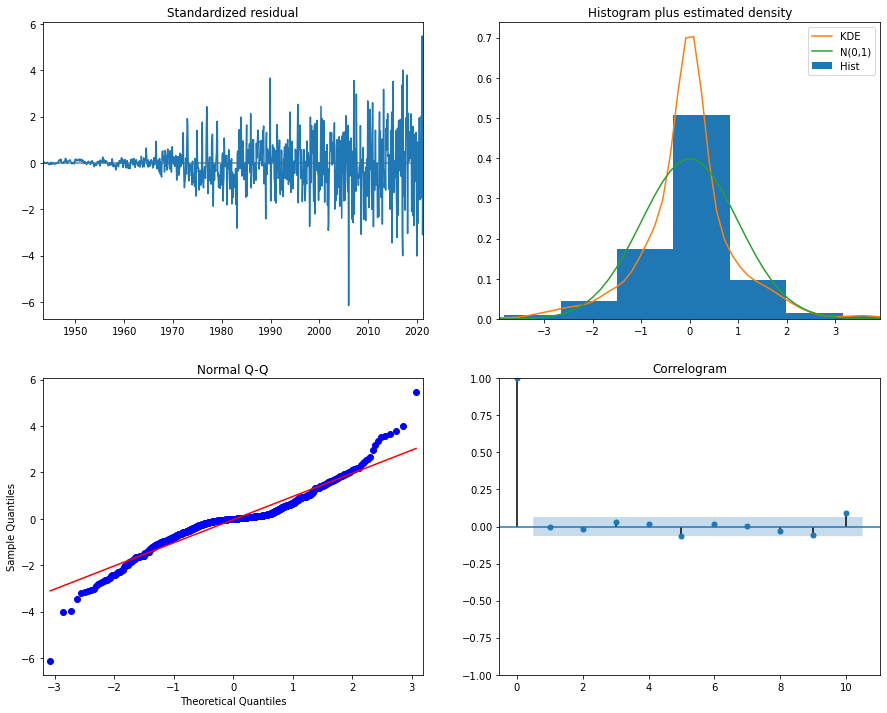

In [73]:
diag = results.plot_diagnostics(figsize=(15, 12))

We will create another model with only the significant features. 

In [93]:
mod = sm.tsa.statespace.SARIMAX(df2,
                                order=(1, 1, 1),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                       Energy_Production   No. Observations:                  989
Model:             SARIMAX(1, 1, 1)x(1, 2, [1, 2], 12)   Log Likelihood               -1913.004
Date:                                 Sat, 17 Jul 2021   AIC                           3838.008
Time:                                         15:49:41   BIC                           3867.071
Sample:                                     01-01-1939   HQIC                          3849.088
                                          - 05-01-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5282      0.024     22.071      0.000       0.481       0

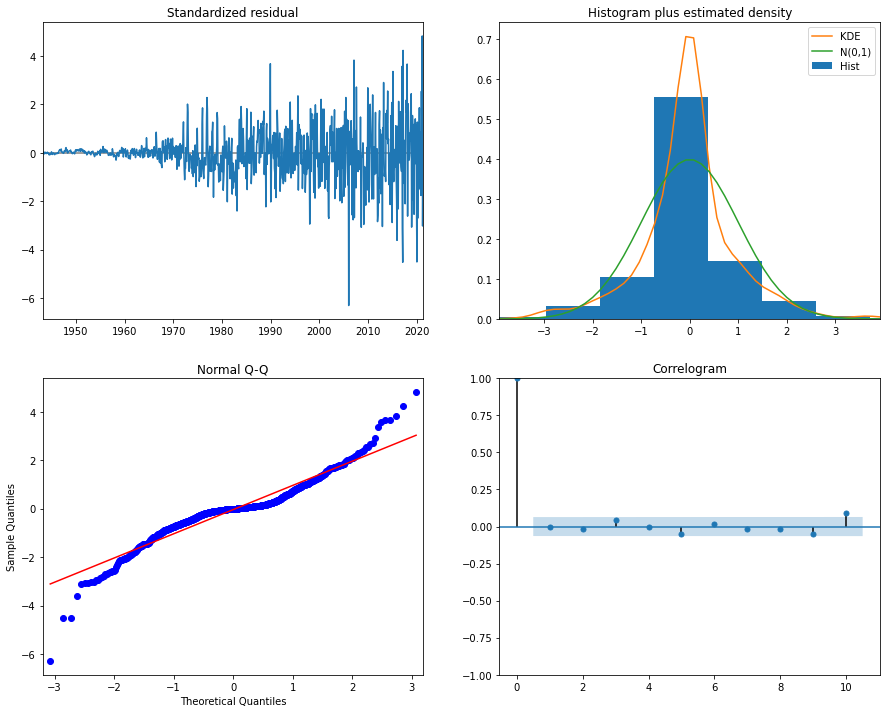

In [75]:
diag = results.plot_diagnostics(figsize=(15, 12))

In [76]:
residuals = pd.DataFrame(results.resid)
print(residuals.describe())

                0
count  989.000000
mean    -0.065359
std      1.761243
min    -11.333992
25%     -0.689987
50%     -0.013401
75%      0.429662
max      8.680409


We can conclude that the residuals approximately follow a normal distribution and are uncorrelated. All the AR and MA terms in the model are significant. Therefore , we will use the model ARIMA (1,1,1)(1,2,2)12

# Validating Forecasts

In [77]:
pred = results.get_prediction(start=pd.to_datetime('2016-05-01'), dynamic=False)

<Figure size 1440x288 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Energy Production')

<Figure size 1440x288 with 0 Axes>

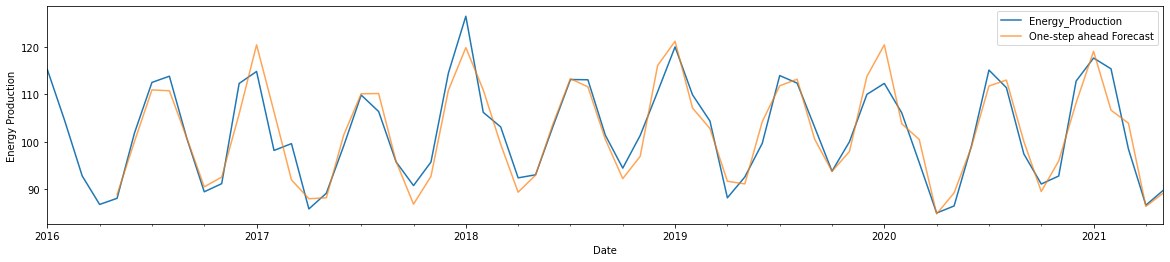

In [82]:
plt.figure(figsize=(20,4))
ax = df2['2016-01-01':].plot(label='observed', figsize=(20,4))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Energy Production')
plt.legend()
plt.show()

We will also measure the MAPE and RMSE of the forecasted data.

In [88]:
get_mape(df2.Energy_Production[928:], pred.predicted_mean) 

2.66

In [87]:
pred.predicted_mean

2016-05-01     88.897126
2016-06-01    100.104826
2016-07-01    110.926191
2016-08-01    110.740744
2016-09-01    100.785351
                 ...    
2021-01-01    119.040804
2021-02-01    106.670791
2021-03-01    103.915096
2021-04-01     86.444605
2021-05-01     89.248499
Freq: MS, Length: 61, dtype: float64

In [89]:
np.sqrt(mean_squared_error(df2.Energy_Production[928:].values, pred.predicted_mean.values))

3.5370957914215273